## Blinded cameras clustering

Here the dataset is a pandas DataFrame generated from a response.drdf file. 
The file can be found at "/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-GRAIN-CALORIMETRY/data/cube_production/production1/cube_X0_Y0_Z-3/output/response_cut.drdf".

In [4]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 


### Read data from pickle format

In [5]:
#module_path = os.path.abspath(os.path.join('..'))
df = pd.read_pickle("blind_cameras_dataset\\drdf_arrays.pkl")
print(df[:5])

  event     source                                             pixels
0  1115  CAM_NB_X0  [[1.034386, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1  1115  CAM_NB_X1  [[2.8447123, 1.9851313, 1.191889, 0.0, 1.02277...
2  1115  CAM_NB_X2  [[0.0, 0.0, 2.0428712, 1.8089218, 1.1883966, 0...
3  1115  CAM_NB_X3  [[3.2495024, 4.1333947, 3.7861702, 0.0, 0.0, 0...
4  1115  CAM_NB_X4  [[0.0, 0.0, 0.0, 1.105229, 2.885855, 0.0, 1.99...


Compose data array from dataframe column, keeping different cameras in the rows, while columns represent the pixels

In [6]:
df2arr = df.pixels.to_numpy()
arr3d = np.stack(df2arr)
data = arr3d.reshape(df2arr.shape[0],32*32)

print('data array with shape:',df2arr.shape)

data array with shape: (46968,)


In [ ]:
# if supervised algorithm, need to create labe array
# data_label = .....

In [31]:
# NB this os the proof of how the reshape method works!!
# t0 = test[0]
# t1 = test1[0]
# d = np.empty(0)
# for i in range(32):
#     for j in range(32):
#         diff = t0[i,j] - t1[i*32+j]
#         d = np.append(d,diff)
        
# print(np.min(d), np.max(d))

### Show distribution of data from the entire file

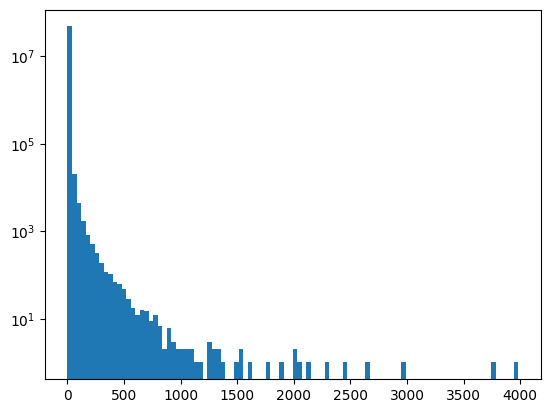

In [7]:
plt.hist(data.reshape(-1,1),100)
plt.yscale('log')

#### Find cameras with an excess of photons *
NB. this excess must be defined using some algorithm

In [32]:
tw = np.where(data>50)
blind_candidate = np.unique(tw[0])
print('cameras with excess photons: ', blind_candidate.size)
print(blind_candidate)

cameras with excess photons:  527
[   58    63    64    69   473   595   671   853   904   970   972   975
   976  1005  1127  1134  1203  1274  1285  1507  1518  1603  1841  2069
  2373  2494  2496  2723  2799  2804  2874  3133  3284  3402  3787  3863
  4013  4086  4167  4390  4395  4553  4623  4957  5000  5154  5155  5230
  5308  5458  5462  5463  5465  5489  5763  5914  6067  6249  6295  6446
  6447  6533  6599  6611  6675  6749  6906  6978  7161  7283  7360  7508
  7510  7842  7902  7968  8044  8068  8077  8276  8347  8499  8529  8574
  8575  8576  8579  8605  8651  8655  8682  8803  8946  9105  9107  9223
  9423  9631  9699  9791  9826  9897  9943 10100 10154 10165 10167 10171
 10201 10247 10466 10469 10581 10632 10855 10886 10926 11054 11235 11265
 11387 11468 11534 11548 11553 11569 11620 12253 12299 12329 12481 12633
 12678 12983 13242 13287 13291 13363 13364 13428 13506 13591 13673 13696
 13969 13971 13981 14002 14053 14199 14229 14351 14357 14500 14533 14655
 14660 14839 1487

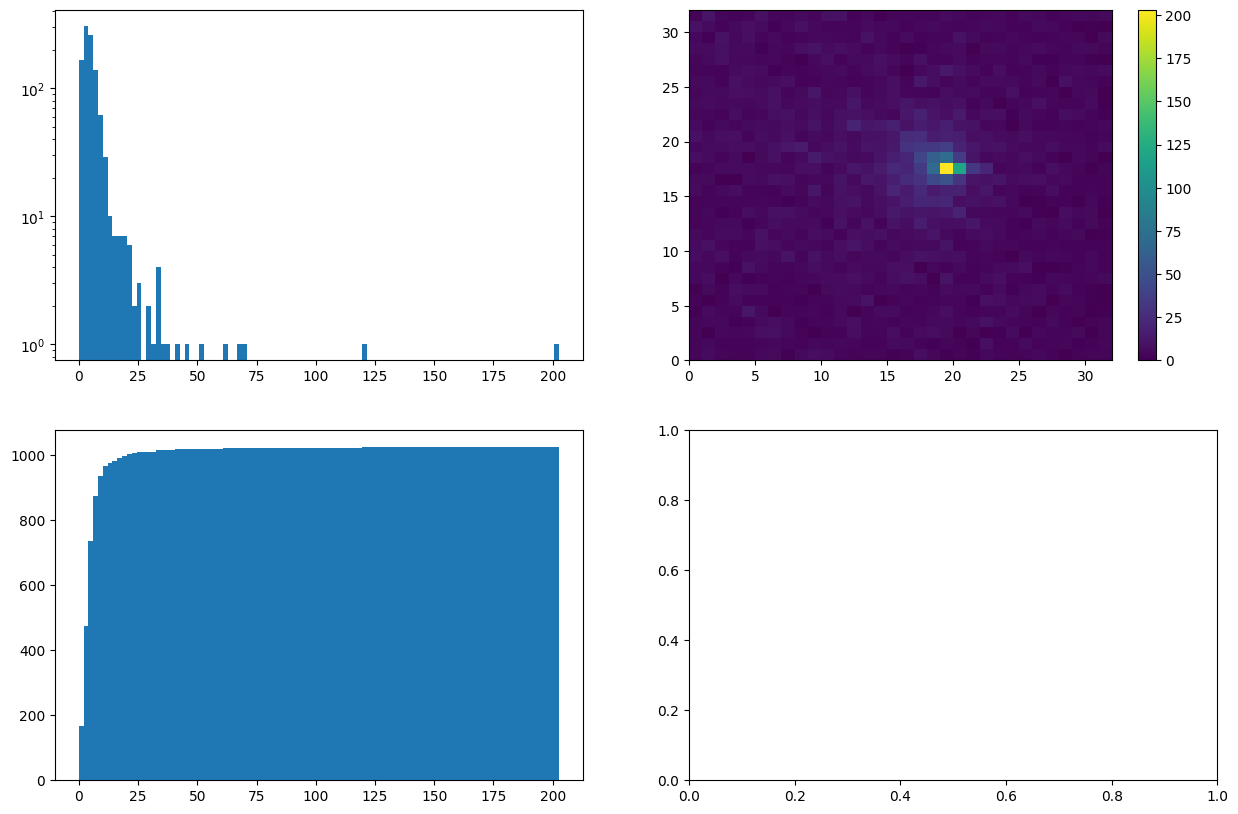

In [40]:
data_num = 58

fig, ax = plt.subplots(2,2)
ax[0,0].hist(data[data_num],100)
ax[0,0].set_yscale('log')

camera = np.reshape(df.iloc[162].pixels, (32,32))
cam = ax[0,1].pcolormesh(arr3d[data_num])
plt.colorbar(cam)

ax[1,0].hist(data[data_num], 100, cumulative=True)

fig.set_figwidth(15)
fig.set_figheight(10)

Use the KMean algorithm to clusterise the datasample.
The same data are the processed to check the clusterization.

In [5]:
from sklearn.cluster import KMeans

# Declaring Model
model = KMeans(n_clusters=2)

# Fitting Model
model.fit(dataT)

# Prediction on the entire data
all_predictions = model.predict(dataT)

# Printing Predictions
print(all_predictions)

[0 0 0 ... 0 0 0]


In [6]:
print(all_predictions.shape)
print(np.count_nonzero(all_predictions == 0))
print(np.count_nonzero(all_predictions == 1))
print(np.where(all_predictions == 1))

(1001,)
1000
1
(array([854], dtype=int64),)


In [7]:
df.iloc[854]

event                                                  1977
source                                         CAM_NE_X2_Y3
pixels    [[1.0548458, 7.31901, 2.2687764, 3.7038498, 5....
Name: 854, dtype: object

Plot an example of camera from cluster "1". For this cluster doesn't seem to contain blinded cameras.

**Could this be due to a small number of true blinded cameras in this sample??**

In some way I should plot all the cameras of the sample to find the effective number of blinded cameras

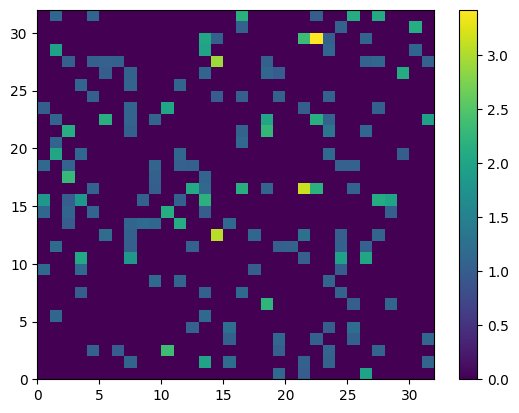

In [8]:
camera = np.reshape(df.iloc[162].pixels, (32,32))
plt.pcolormesh(camera)
plt.colorbar()